### Data Summary
#### Stores
- Anonymized information about 45 stores, indicating the type and size of the store.
- Stores: are numbered 1 - 45
- Types: I see there are 3 types of stores A,B,C apparently categorical based on the size
- Size: I think it is the store capacity. Size is ranging from ~30k -220k

#### Features
Contains additional data related to the store, department, and regional activity for the given dates.
- Store: store number 1 - 45
- Date: Date of the week when the data was recorded 
- mperature: average temperature in the region
- Fuel_Price: cost of fuel in the region
- MarkDown1-5: - anonymized data related to promotional markdowns. MarkDown data is only available
after Nov 2011 and is not available for all stores all the time. Any missing value is marked with an NA
- CPI: the consumer price index
- Unemployment: the unemployment rate
- IsHoliday: boolean, whether the week is a special holiday week

#### Sales
- Store - store number
- Dept - department number
- Date – week number
- Weekly_Sales - sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week

In [23]:
# Import libraries to be used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [4]:
## Data Source: https://www.kaggle.com/manjeetsingh/retaildataset
# read the ['Features data set.csv', 'sales data-set.csv', 'stores data-set.csv'] from the /data folder
import os
print("current directory is : " + os.getcwd()) 
print('the /data folder contains:') 
print(os.listdir("./data"))

stores = pd.read_csv('./data/stores data-set.csv')
features = pd.read_csv('./data/Features data set.csv')
sales = pd.read_csv('./data/sales data-set.csv')

current directory is : C:\Users\Dragos\projects\retail_kaggle
the /data folder contains:
['Features data set.csv', 'sales data-set.csv', 'stores data-set.csv']


In [5]:
######## 1. Understand the data and cleanup ##############

In [6]:
######## 1.1 stores dataset ############### 
# many stores, categorical Type and the Size of the shop?
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


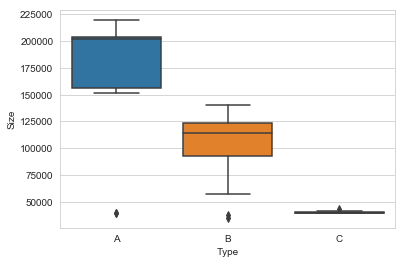

In [7]:
# Apparently there are 3 types of stores, each type belongs to a size range
sns.set_style('whitegrid')
sns.boxplot(x='Type',y='Size', data=stores)

In [8]:
stores['Type'].value_counts()
print(stores.dtypes)
print(stores.isna().sum())

Store     int64
Type     object
Size      int64
dtype: object
Store    0
Type     0
Size     0
dtype: int64


In [9]:
######## 1.2 features dataset ############### 

In [10]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
Store           8190 non-null int64
Date            8190 non-null object
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
MarkDown1       4032 non-null float64
MarkDown2       2921 non-null float64
MarkDown3       3613 non-null float64
MarkDown4       3464 non-null float64
MarkDown5       4050 non-null float64
CPI             7605 non-null float64
Unemployment    7605 non-null float64
IsHoliday       8190 non-null bool
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 711.9+ KB


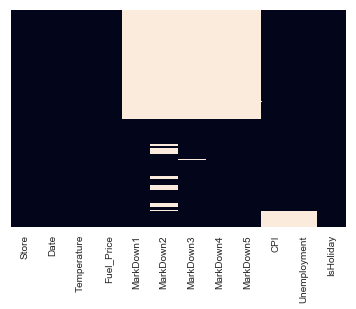

In [11]:
# get a grasp on how the missing data is distrubuted accros one store
# we already know that MarkDown data is only available after Nov 2011 and is not available for all stores all the time. 
# CPI and unemployment are missing sometimes, I can fill in NaN-s wit hthe last known value for that period
sns.heatmap(features[features['Store'].eq(1)].isnull(),cbar=False,yticklabels=False)

In [12]:
# Is now the data clean? Yes
features.isna().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [13]:
## I don't intend to use so instead of replacing na-s with 0 I better drop them all
markdown_cols = features.filter(like='MarkDown').columns
for column in markdown_cols:
     features = features.drop(column,axis=1)

# On features Fill na gaps forward on CPI and Unemployment, Data seems sorted by date already
# https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html
features['CPI'] = features['CPI'].fillna(method='pad')
features['Unemployment'] = features['Unemployment'].fillna(method='pad')

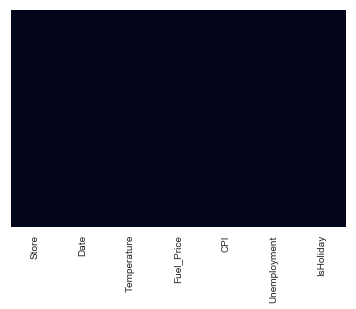

In [14]:
sns.heatmap(features[features['Store'].eq(1)].isnull(),cbar=False,yticklabels=False)

In [15]:
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [16]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [17]:
# Is the data clean? Yes
sales.isna().sum().sum()

0

In [18]:
# merge left all tables, use only keys from left frame, similar to a SQL left outer join; preserve key order.
    
retail = pd.merge(sales, features, how = 'left', on = ['Store', 'Date', 'IsHoliday'])
retail = pd.merge(retail, stores, how = 'left', on = ['Store'])

# format date in datetime, we need it to extract Year and Year week later to split the data in train, test
retail['Date'] = pd.to_datetime(retail['Date'])
retail['Year'] = pd.DatetimeIndex(retail['Date']).year
retail['Month'] = pd.DatetimeIndex(retail['Date']).month

retail['Year-Week'] = retail['Date'].dt.strftime('%Y-%U')

# I noticed there are Sales figures that are negative, cleanup:
retail = retail[retail['Weekly_Sales']>=0]

# turn IsHoliday into an Integer, useful later for numeric computations
retail['IsHoliday'] = retail['IsHoliday'].astype(int)

# Sort by Date as the data is not ordered by Date
retail = retail.sort_values(by=['Date'])

# checkout the dataset we're going to use further
retail.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Year,Month
count,420285.000000,420285.000000,420285.000000,420285.00000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000
mean,22.195477,44.242771,16030.329773,0.07034,60.090474,3.360888,171.212152,7.960077,136749.569176,2010.968443,6.478501
std,12.787213,30.507197,22728.500149,0.25572,18.448260,0.458523,39.162280,1.863873,60992.688568,0.796893,3.324688
min,1.000000,1.000000,0.000000,0.00000,-2.060000,2.472000,126.064000,3.879000,34875.000000,2010.000000,1.000000
25%,11.000000,18.000000,2117.560000,0.00000,46.680000,2.933000,132.022667,6.891000,93638.000000,2010.000000,4.000000
50%,22.000000,37.000000,7659.090000,0.00000,62.090000,3.452000,182.350989,7.866000,140167.000000,2011.000000,6.000000
75%,33.000000,74.000000,20268.380000,0.00000,74.280000,3.738000,212.445487,8.567000,202505.000000,2012.000000,9.000000
max,45.000000,99.000000,693099.360000,1.00000,100.140000,4.468000,227.232807,14.313000,219622.000000,2012.000000,12.000000


In [17]:
# checkout the timeseries date range
print(retail['Date'].min())
print(retail['Date'].max())

2010-01-10 00:00:00
2012-12-10 00:00:00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000011DDA860>],
      dtype=object)

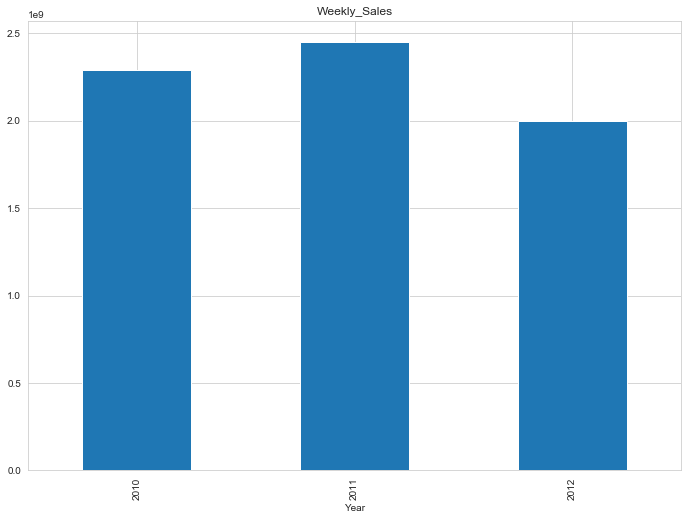

In [18]:
YearSales = retail.groupby(['Year'])['Weekly_Sales'].agg('sum')
# print(type(YearSales))
# print(YearSales.dtypes)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
YearSales.plot.bar(subplots=True)

Text(0.5, 1.0, 'Monthly Sales')

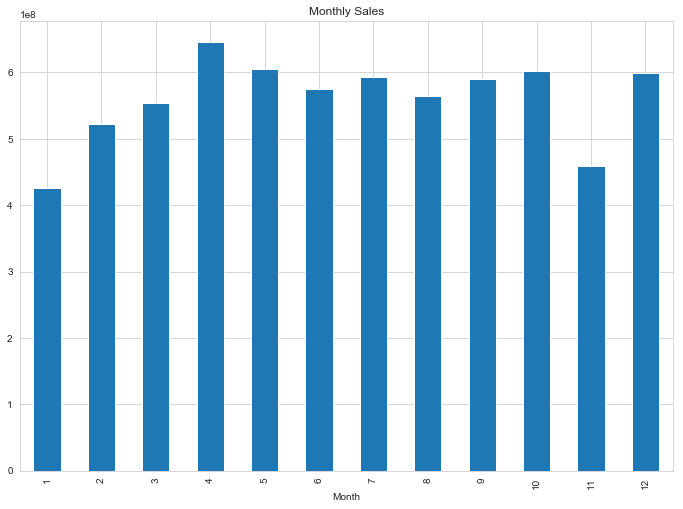

In [19]:
MonthSales = retail.groupby(['Month'])['Weekly_Sales'].agg('sum')

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
MonthSales.plot.bar(subplots=True, x='Month', y='Monthly_Sales', ax=ax, legend=False )
ax.set_title('Monthly Sales')

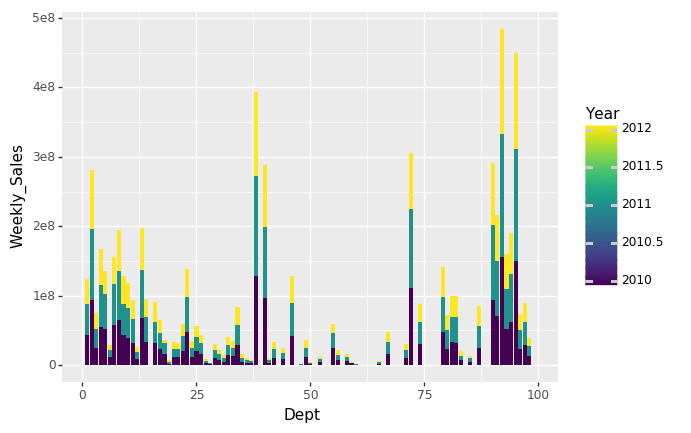

<ggplot: (-9223372036836248197)>

In [20]:
# http://www.xavierdupre.fr/app/jupytalk/helpsphinx/notebooks/im_plotnine.html
from plotnine import *
(ggplot(retail, aes(x='Dept', y='Weekly_Sales', fill='Year')) + geom_col())


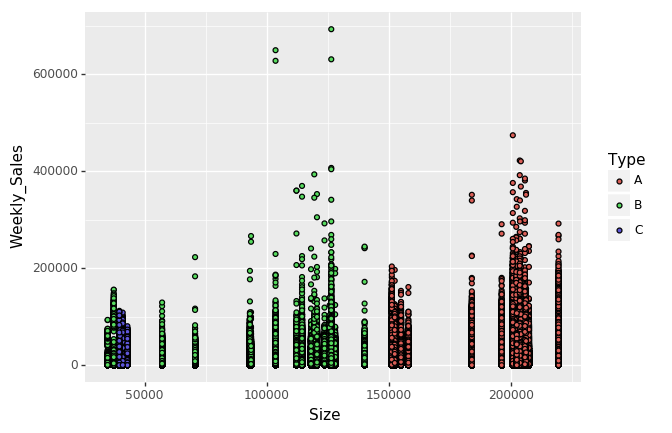

<ggplot: (15894371)>

In [21]:
(ggplot(retail, aes(x='Size', y='Weekly_Sales', fill ='Type')) + geom_point())

In [ ]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

hot = plt.get_cmap('hot')
uniq = list(set(YearlySales['Type']))
cNorm = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

# Plot each Type
for i in range(len(uniq)):
    indx = YearlySales['Type'] == uniq[i]
    plt.scatter(YearlySales[indx]['Size'], YearlySales[indx]['Total_Sales'],s=10, color=scalarMap.to_rgba(i), label=uniq[i])
    plt.xlabel('Size')
    plt.ylabel('Total Size')
    plt.title('Store Size and Sales')
    plt.legend(loc='upper left')
    
plt.show()

In [ ]:
# http://jonathansoma.com/lede/data-studio/classes/small-multiples/long-explanation-of-using-plt-subplots-to-create-small-multiples/
# Make the graph 20 inches by 40 inches
plt.figure(figsize=(20,40), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for dept, selection in retail.groupby(['Dept']):
    # Inside of an image that's a 15x6 grid, put this
    # graph in the in the plot_number slot.
    print=(selection.head())
    ax = plt.subplot(15, 6, plot_number)
    #YearSales = retail.groupby(['Year'])['Weekly_Sales'].agg('sum')
    YearSales = selection.groupby(['Year'])['Weekly_Sales'].agg('sum')
    
    YearSales.plot.bar(subplots=True, x='Year', y='Weekly_Sales', ax=ax)
    ax.set_title(dept)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

## check that the barcharts are right
'''
YearSales = retail[retail['Dept']==77].groupby(['Year'])['Weekly_Sales'].agg('sum')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
YearSales.plot.bar(subplots=True)
'''

In [ ]:
(ggplot(retail, aes(x='Size', y='Weekly_Sales', fill ='Type')) + geom_point())

In [ ]:
# Looking at the store numbers by Sales
# https://www.r-bloggers.com/ggplot2-style-plotting-in-python/
(ggplot(retail, aes(x='Store', y='Weekly_Sales')) + geom_point() + facet_wrap('Year'))


In [ ]:
# Sales by month and temperature by month
sales_m = pd.Series(retail.groupby(['Month'])['Weekly_Sales'].agg('sum'))
temperature_m = pd.Series(retail.groupby(['Month'])['Temperature'].agg('mean'))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Weekly_Sales', color=color)
ax1.plot(sales_m, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Temperature', color=color)  # we already handled the x-label with ax1
ax2.plot(temperature_m, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
# Sales by month and unemployment by month
unempl_m = pd.Series(retail.groupby(['Month'])['Unemployment'].agg('mean'))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Weekly_Sales', color=color)
ax1.plot(sales_m, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Unemployment', color=color)  # we already handled the x-label with ax1
ax2.plot(unempl_m, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
# Sales by month and CPI by month
cpi_m = pd.Series(retail.groupby(['Month'])['CPI'].agg('mean'))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Weekly_Sales', color=color)
ax1.plot(sales_m, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('CPI', color=color)  # we already handled the x-label with ax1
ax2.plot(cpi_m, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
# Holiday Sales in Weekly Sales
(ggplot(retail, aes(x='Date', y='Weekly_Sales', fill ='IsHoliday')) + geom_point())

In [ ]:
# Looking at the store numbers by Sales
# https://www.r-bloggers.com/ggplot2-style-plotting-in-python/
YearSales = retail[retail['Year']==2010].groupby(['Type'])['Weekly_Sales'].agg('sum')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
YearSales.plot.bar(subplots=True)


In [ ]:
# Analyse relations
d = {'Weekly_Sales':'Total_Sales'}
YearlySales = retail.groupby(['Store','Type','Size'],as_index=False)['Weekly_Sales'].sum().rename(columns=d)

In [ ]:
(ggplot(YearlySales, aes(x='Size', y='Total_Sales', fill ='Type')) 
 + geom_smooth(method = "glm") + geom_point())

In [28]:
# Corelation analysis
# Data analysis: visualisations, corr matrix for the numeric factors for 
col_features = ['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment','Size', 'IsHoliday']

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size,IsHoliday
Weekly_Sales,1.00,-0.00,0.00,-0.02,-0.03,0.24,0.01
Temperature,-0.00,1.00,0.14,0.18,0.10,-0.06,-0.16
Fuel_Price,0.00,0.14,1.00,-0.16,-0.03,0.00,-0.08
CPI,-0.02,0.18,-0.16,1.00,-0.30,-0.00,-0.00
Unemployment,-0.03,0.10,-0.03,-0.30,1.00,-0.07,0.01
Size,0.24,-0.06,0.00,-0.00,-0.07,1.00,0.00
IsHoliday,0.01,-0.16,-0.08,-0.00,0.01,0.00,1.00


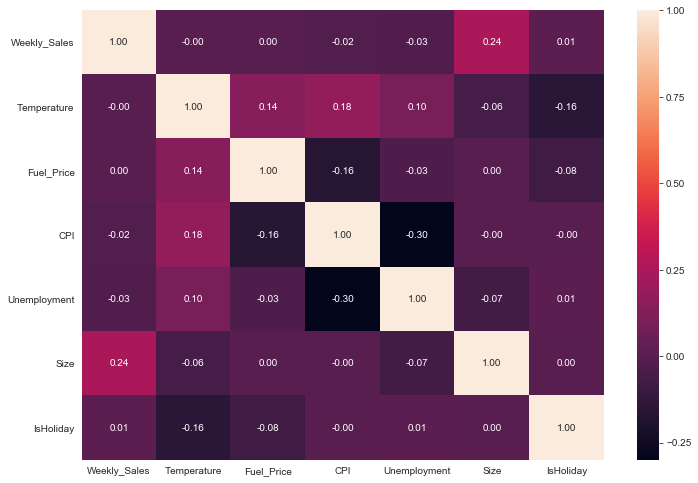

In [29]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(retail[col_features].corr(),annot=True,  fmt='.2f')

In [111]:
# Linear Regression with Scikit-Learn
X_col = ['Unemployment']
y_col = ['Weekly_Sales']
X = retail[X_col]
y = retail[y_col] 

In [112]:
model = LinearRegression()

model.fit(X,y)

In [113]:
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [114]:
model.coef_


array([[-314.99430591]])

In [115]:
model.intercept_

array([18537.70869446])

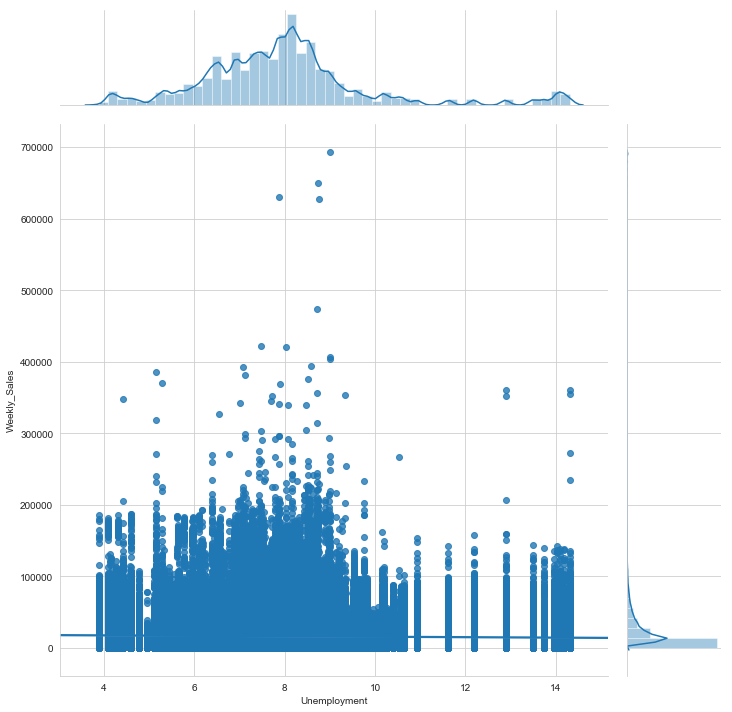

In [117]:
# ax = sns.regplot(x='Unemployment', y='Weekly_Sales', data=retail)
ax = sns.jointplot(x='Unemployment', y='Weekly_Sales', data=retail, kind='reg', height=10)
plt.show();

In [118]:
## RANSACRegressor 
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor()

In [119]:
X_col = ['Unemployment']
y_col = ['Weekly_Sales']
X = retail[X_col]
y = retail[y_col] 

ransac.fit(X,y)

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_skips=inf, max_trials=100,
        min_samples=None, random_state=None, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)

In [120]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

In [127]:
line_X = X[0:5]
line_y_ransac = ransac.predict(line_X)
line_y_ransac



array([[3776.98113533],
       [3659.92989477],
       [3509.61145952],
       [4163.69027144],
       [3297.15905748]])

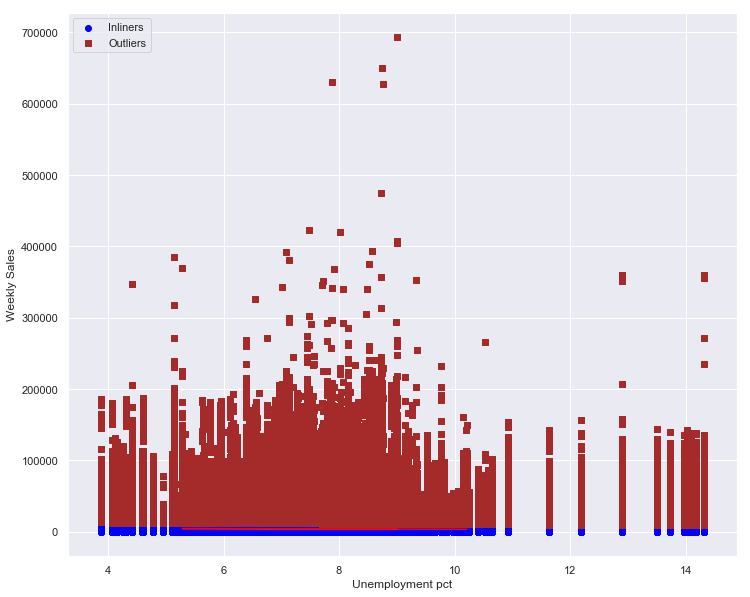

In [129]:
sns.set(style = 'darkgrid', context='notebook')
plt.figure(figsize=(12,10))
plt.scatter(X[inlier_mask],y[inlier_mask], c='blue', marker='o', label='Inliners')
plt.scatter(X[outlier_mask],y[outlier_mask], c='brown', marker='s', label='Outliers')
plt.plot(line_X,line_y_ransac, color = 'red')
plt.xlabel('Unemployment pct')
plt.ylabel('Weekly Sales')
plt.legend(loc='upper left')
plt.show()

In [130]:
ransac.estimator_.coef_

array([[-176.0169031]])

In [132]:
ransac.estimator_.intercept_

array([5094.29163813])

In [32]:
## Performance evaluation of Regression Model with a single factor

X_col = ['Unemployment']
y_col = ['Weekly_Sales']
X = retail[X_col]
y = retail[y_col] 

# Split the data in train test using sklearn 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [33]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [34]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

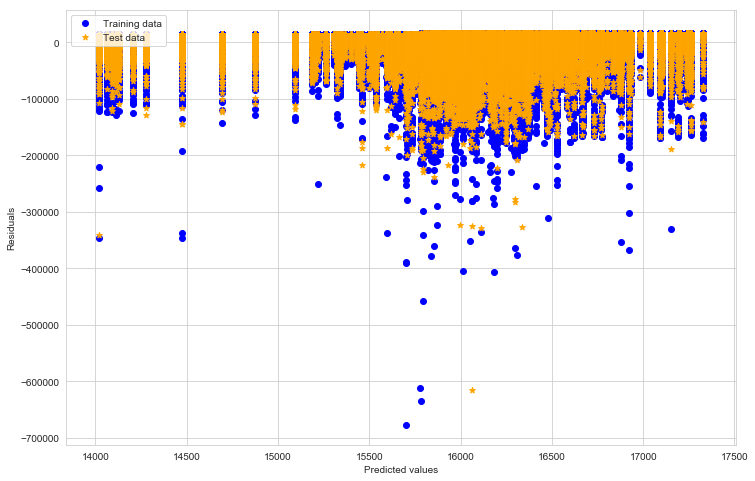

In [35]:
# Method 1: Residual Analysis
# https://www.udemy.com/machine-learning-course-with-python/learn/v4/t/lecture/8454678?start=0
plt.figure(figsize=(12,8))
plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label = 'Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='orange', marker='*', label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
#plt.hlines(y=0,xmin=-10000, xmax=100, lw=2, color='k')
#plt.xlim([-5,35])
plt.show()

In [41]:
# Mean Squered error (MSE) best value is 0
from sklearn.metrics import mean_squared_error

In [42]:
mean_squared_error(y_train, y_train_pred)

518379262.7602791

In [43]:
mean_squared_error(y_test, y_test_pred)

507676992.9656531

In [44]:
# Coefficient of determination (R2), best value is 1
# https://www.udemy.com/machine-learning-course-with-python/learn/v4/t/lecture/8454678?start=0
r2_score(y_train, y_train_pred)

0.0006694776307131223

In [45]:
r2_score(y_test, y_test_pred)

0.0006576831663175353

In [46]:
# Robust regression
#https://www.udemy.com/machine-learning-course-with-python/learn/v4/t/lecture/8454680?start=32
#https://www.statsmodels.org/stable/regression.html
# linear regression with multiple factors
X_col = ['Temperature','Fuel_Price','CPI','Unemployment','Size', 'IsHoliday']
y_col = ['Weekly_Sales']
X = retail[X_col]
y = retail[y_col] 

# Split the data in train test using sklearn 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [47]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [48]:
# Mean Squered error (MSE) best value is 0
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
print(mean_squared_error(y_train, y_train_pred))
print(mean_squared_error(y_test, y_test_pred))

487414047.49015236
475915358.34256256


In [49]:
# Coefficient of determination (R2), best value is 1
# https://www.udemy.com/machine-learning-course-with-python/learn/v4/t/lecture/8454678?start=0
r2_score(y_train, y_train_pred)

0.06036415867639999

In [50]:
# Statsmodel - not needed for data science as the focus is on predictios
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [51]:
X_constant = sm.add_constant(X)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [53]:
pd.DataFrame(X_constant).head()

,const,Temperature,Fuel_Price,CPI,Unemployment,Size,IsHoliday
187941,1.0,61.08,2.707,204.885097,7.484,203742,0
250485,1.0,57.80,2.717,132.756800,8.149,152513,0
92954,1.0,86.01,3.001,126.234600,9.003,126512,0
217425,1.0,62.07,2.717,132.756800,5.287,114533,0
402322,1.0,77.93,2.603,203.593429,10.210,41062,0


In [55]:
#sm.OLS?
model = sm.OLS(y,X_constant)

In [56]:
ls = model.fit()

In [59]:
ls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     4544.
Date:                Fri, 26 Apr 2019   Prob (F-statistic):               0.00
Time:                        21:52:46   Log-Likelihood:            -4.7992e+06
No. Observations:              420285   AIC:                         9.598e+06
Df Residuals:                  420278   BIC:                         9.598e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         8582.5955    399.777     21.468      0.000    7799.046    9366.145
Temperature     29.1815      1.960     14.889      0.000      25.340      33.023
Fuel_Price    -447.3787     77.004     -5.810      0.000    -598.304    -296.453
CPI            -18.8442      0.957    -19.682      0.000     -20.721     -16.968
Unemployment  -264.1733     19.552    -13.511      0.000    -302.495    -225.852
Size             0.0909      0.001    162.531      0.000       0.090       0.092
IsHoliday     1405.5195    134.804     10.426      0.000    1141.308    1669.731
==============================================================================
Omnibus:                   307134.956   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9487223.809
Skew:                           3.190   Prob(JB):                         0.00
Kurtosis:                      25.384   Cond. No.                     1.78e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""